In [29]:
from ga.numba_ga import GaHMM
from data.data import Observations
import pandas
import ga.crossover as crossover
import ga.mutation as mutation
import numpy
import seaborn as sns

In [ ]:
def create_empty_dataframe_from_dtypes_dict(dtypes_dict):
    for (col_name, dtype) in dtypes_dict.items():
        dtypes_dict[col_name] = pandas.Series(dtype=dtype)
    return pandas.DataFrame(dtypes_dict)

shared_columns_dtypes = {
    'dataset': str,
    'n_seqs': int,
    'n_symbols': int,
    'n_states': int,
    'n_bw_iterations': int,
}

crossover_columns_dtypes = {
    **shared_columns_dtypes,
    'crossover_func': str,
    'parent1_fitness': float,
    'parent2_fitness': float,
    'child_fitness': float
}

mutation_columns_dtypes = {
    **shared_columns_dtypes,
    'mutation_func': str,
    'fitness_before_mutation': float,
    'fitness_after_mutation': float,
}

crossover_df = create_empty_dataframe_from_dtypes_dict(crossover_columns_dtypes)
mutation_df = create_empty_dataframe_from_dtypes_dict(mutation_columns_dtypes)

In [79]:
crossover_functions = {
    '1X': crossover.n_point_crossover_factory(n_crossover_points=1),
    '2X': crossover.n_point_crossover_factory(n_crossover_points=2),
    'ARITHMETIC_MEAN': crossover.arithmetic_mean_crossover,
    'UNIFORM': crossover.uniform_crossover,
}

mutation_functions = {
    'UNIFORM_0.1': mutation.constant_uniform_mutation_factory(0.1),
    'UNIFORM_0.01': mutation.constant_uniform_mutation_factory(0.01),
    'UNIFORM_0.001': mutation.constant_uniform_mutation_factory(0.001),
}

params = [
    {
        'dataset_name': 'fsdd',
        'n_symbols': 128,
        'n_seqs': 10,
        'observation_category': 0,
        'n_states': 5,
        'population_size': 1000,
    }
    # {
    #     'dataset_name': 'orl',
    #     'n_symbols': 16,
    #     'n_seqs': 10,
    #     'observation_category': 0,
    #     'n_states': 20,
    #     'population_size': 10,
    # }
]

In [80]:
n_bw_iterations_list = numpy.arange(20)
# observation_sequences = Observations()
mutation_df_rows = []


for params_dict in params:
    (dataset_name, n_symbols, n_seqs, observation_category, n_states, population_size) = params_dict.values()

    dataset = Observations(dataset_name, n_symbols)
    observation_seqs = dataset.get_first_n_observations_of_category(observation_category, n_seqs)
    
    for observations in observation_seqs:

        for n_bw_iterations in n_bw_iterations_list:
            ga = GaHMM(
                n_symbols, 
                n_states, 
                population_size,
                n_generations=0,
                observations=observation_seqs)
            ga.n_bw_iterations_before_ga = n_bw_iterations
            ga.start()

            hmm_params = 

            # generate hmm params
            # read fitness into arr

            unmutated_fitness_values = ga.population[:, ga.ranges.fitness.start]
            fitness_before_mutation = unmutated_fitness_values[pop_index]

            for mutation_func_name, mutation_func in mutation_functions.items():
                ga.mutation_func = mutation_functions[mutation_func_name]

                mutated_population = ga.do_mutation_step(ga.population)
                mutated_fitness_values = ga.calculate_fitness_values(mutated_population).flatten()
                
                for pop_index in range(population_size):
                    
                    fitness_after_mutation = mutated_fitness_values[pop_index]
                    row = {
                        'dataset': dataset_name,
                        'n_seqs': n_seqs,
                        'n_symbols': n_symbols,
                        'n_states': n_states,
                        'n_bw_iterations': n_bw_iterations,
                        'mutation_func': mutation_func_name,
                        'fitness_before_mutation': fitness_before_mutation,
                        'fitness_after_mutation': fitness_after_mutation,
                    }
                    mutation_df_rows.append(row)


mutation_df = pandas.DataFrame(mutation_df_rows)

In [96]:
mutation_df['percentage_increase'] = (mutation_df['fitness_after_mutation'] - mutation_df['fitness_before_mutation'])
mutation_df

,dataset,n_seqs,n_symbols,n_states,n_bw_iterations,mutation_func,fitness_before_mutation,fitness_after_mutation,percentage_increase
0,fsdd,10,128,5,0,UNIFORM_0.1,-2697.766012,-2780.766947,-83.000935
1,fsdd,10,128,5,0,UNIFORM_0.1,-2697.766012,-2663.353322,34.412690
2,fsdd,10,128,5,0,UNIFORM_0.1,-2697.766012,-2716.565138,-18.799126
3,fsdd,10,128,5,0,UNIFORM_0.1,-2697.766012,-2696.204692,1.561320
4,fsdd,10,128,5,0,UNIFORM_0.1,-2697.766012,-2939.622292,-241.856280
...,...,...,...,...,...,...,...,...,...
179995,fsdd,10,128,5,19,UNIFORM_0.001,-1503.499197,-1730.758591,-227.259394
179996,fsdd,10,128,5,19,UNIFORM_0.001,-1503.499197,-1582.788711,-79.289514
179997,fsdd,10,128,5,19,UNIFORM_0.001,-1503.499197,-1531.121507,-27.622310
179998,fsdd,10,128,5,19,UNIFORM_0.001,-1503.499197,-1793.536081,-290.036884


In [106]:
mutation_df[mutation_df['n_bw_iterations'] == 0].mean()

C:\Users\imigs\AppData\Local\Temp\ipykernel_18416\368072225.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mutation_df[mutation_df['n_bw_iterations'] == 0].mean()


n_seqs                       10.000000
n_symbols                   128.000000
n_states                      5.000000
n_bw_iterations               0.000000
fitness_before_mutation   -2987.548631
fitness_after_mutation    -2923.417654
percentage_increase          64.130977
dtype: float64

<AxesSubplot: xlabel='n_bw_iterations', ylabel='fitness_after_mutation'>

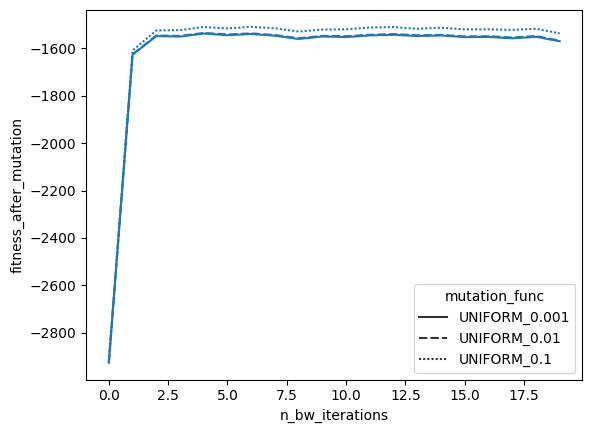

In [99]:
series = mutation_df.groupby(['mutation_func', 'n_bw_iterations'])['fitness_after_mutation'].mean()
df = pandas.DataFrame(series).reset_index()
sns.lineplot(df, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func')

In [94]:
df2 = mutation_df[mutation_df['mutation_func']== 'UNIFORM_0.001'].groupby('n_bw_iterations')['fitness_before_mutation'].mean()

# sns.scatterplot(mutation_df, x='fitness_before_mutation', y='fitness_after_mutation', hue='mutation_func')
# mutation_df[mutation_df['n_bw_iterations'] == 0]
# pandas.concat(df, df2)
df2 = pandas.DataFrame(df2).reset_index()
df2['mutation_func'] = 'No Mutation'
df2 = df2.rename(columns={'fitness_before_mutation': 'fitness_after_mutation'})
df3 = pandas.concat([df, df2])

<AxesSubplot: xlabel='n_bw_iterations', ylabel='fitness_after_mutation'>

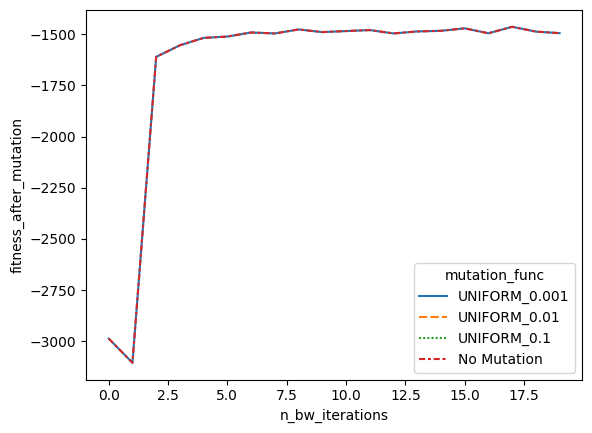

In [95]:
sns.lineplot(df3, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func', hue='mutation_func')